## first level analysis pipeline using nipype

In [9]:
import os
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
import nilearn.plotting

### set up

In [2]:
experiment_dir = '/output'
# output_dir = 'first_level' # masked data results
output_dir = 'first_level_nomask' # non masked preproc data
working_dir = 'workingdir'

TR = 2. # TR of functional images

### specify nodes

In [3]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

### specify GLM contrasts

sanity check of high vs low pain

In [4]:
# condition names
condition_names = ['High','Low']

# contrasts
cont01 = ['average', 'T', condition_names, [.5, .5]]
cont02 = ['High',    'T', condition_names, [1, 0]]
cont03 = ['Low',     'T', condition_names, [0, 1]]
cont04 = ['High>Low','T', condition_names, [1,-1]]
cont05 = ['Low>High','T', condition_names, [-1,1]]

contrast_list = [cont01, cont02, cont03, cont04, cont05]

### specify GLM model

In [5]:
import pandas as pd
trialinfo = pd.read_csv('../data/fmri_behavioural.csv')
trialinfo.head(10)

,subject,session,trial,seq,rt,gen_p1g2,gen_p2g1,prob_pxl,prob_obs,obs_p1g2,obs_p2g1,obs_p1g1,obs_p2g2,obs_p1,obs_p2,obs_p,runtime
0,6,1,1,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.60
1,6,1,2,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10
2,6,1,3,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.60
3,6,1,4,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.05
4,6,1,5,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.60
5,6,1,6,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.20
6,6,1,7,1,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.80
7,6,1,8,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.25
8,6,1,9,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.80
9,6,1,10,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.40


In [6]:
# construct df
# df_sj6 = trialinfo[(trialinfo['subject']==6) & (trialinfo['session']==1)]
df_sj6 = trialinfo[trialinfo['subject']==6]
sj_info = pd.DataFrame()
sj_info['onset'] = df_sj6['runtime']
sj_info['duration'] = 0.
sj_info['weight'] = 1.
trial_type = df_sj6['seq'].replace({1:'Low', 2:'High'})
sj_info['trial_type'] = trial_type
sj_info

,onset,duration,weight,trial_type
0,1.60,0.0,1.0,High
1,3.10,0.0,1.0,High
2,4.60,0.0,1.0,High
3,6.05,0.0,1.0,High
4,7.60,0.0,1.0,High
...,...,...,...,...
1295,475.45,0.0,1.0,Low
1296,476.85,0.0,1.0,Low
1297,478.30,0.0,1.0,High
1298,479.75,0.0,1.0,High


In [7]:
for group in sj_info.groupby('trial_type'):
    print(group)
    print("")

('High',        onset  duration  weight trial_type
0       1.60       0.0     1.0       High
1       3.10       0.0     1.0       High
2       4.60       0.0     1.0       High
3       6.05       0.0     1.0       High
4       7.60       0.0     1.0       High
...      ...       ...     ...        ...
1289  459.55       0.0     1.0       High
1290  461.10       0.0     1.0       High
1297  478.30       0.0     1.0       High
1298  479.75       0.0     1.0       High
1299  481.35       0.0     1.0       High

[667 rows x 4 columns])

('Low',        onset  duration  weight trial_type
6      10.80       0.0     1.0        Low
10     16.90       0.0     1.0        Low
16     25.90       0.0     1.0        Low
22     41.70       0.0     1.0        Low
24     44.80       0.0     1.0        Low
...      ...       ...     ...        ...
1292  464.10       0.0     1.0        Low
1293  465.65       0.0     1.0        Low
1294  467.05       0.0     1.0        Low
1295  475.45       0.0     1.0   

### checking confounds

In [8]:
subject_id = 6
confounds_dir = f'/data/sub-%02d/func/' % subject_id

In [10]:
conf_df = pd.read_csv(confounds_dir+'sub-06_task-tsl_run-2_desc-confounds_regressors.tsv',
                     sep='\t')

In [159]:
# conf_df.columns.values

In [11]:
def select_confounds(subject_id, run_num):
    """select confounds for regressor"""
    confounds_dir = f'/data/sub-%02d/func/' % subject_id
    confounds_file = confounds_dir+f'sub-%02d_task-tsl_run-%d_desc-confounds_regressors.tsv' % (subject_id, run_num)
    conf_df = pd.read_csv(confounds_file, sep='\t')
    conf_names = ['csf','white_matter','global_signal','std_dvars','dvars', 'framewise_displacement',
                 't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02', 't_comp_cor_03',
                  'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
                  'a_comp_cor_04', 'a_comp_cor_05', 
                  'trans_x', 'trans_y', 'trans_z', 'rot_x','rot_y','rot_z',
                  'motion_outlier00', 'motion_outlier01','motion_outlier02', 'motion_outlier03']
    conf_select = conf_df[conf_names].loc[4:]
    conf_select_list = [conf_select[col].values for col in conf_select] # ignore first 4 dummy scans
    return conf_select_list

In [12]:
print(len(select_confounds(6, 2)))
print(len(select_confounds(6, 2)[0]))

26
242


In [86]:
def find_runs(subject_id):
    """find available runs from func"""
    from glob import glob
    func_dir = f'/output/smooth/preproc/sub-%02d/' % int(subject_id)
    func_files = glob(func_dir+'*bold.nii')
    runs = []
    for f in func_files:
        tmp = f.split('_')
        run = tmp[2].split('-')[1]
        runs.append(int(run))
    return sorted(runs)

In [88]:
find_runs('06')

[1, 2, 3, 4, 5]

In [12]:
# def list_subject(data_dir='/output/smooth/preproc/'):
def list_subject(data_dir='/output/smooth_nomask/preproc/'):
    """list all available subjects"""
    sj_ls = []
    for f in os.listdir(data_dir):
        sj_ls.append(f.split('-')[1])
    return sj_ls

In [13]:
len(list_subject())

33

### specify helper function to read subject info

In [43]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    def construct_sj(trialinfo, subject_id, run_num, cond_name):
        # construct df
        df_sj = trialinfo[(trialinfo['subject']==int(subject_id)) & (trialinfo['session']==int(run_num))]
        sj_info = pd.DataFrame()
        sj_info['onset'] = df_sj['runtime']
        sj_info['duration'] = 0.
        sj_info['weight'] = 1.
        trial_type = df_sj['seq'].replace({1:'Low', 2:'High'})
        sj_info['trial_type'] = trial_type
        sj_info_cond = sj_info[sj_info['trial_type']==cond_name]
        return sj_info_cond

    def select_confounds(subject_id, run_num, conf_names):
        """select confounds for regressor"""
        confounds_dir = f'/data/sub-%02d/func/' % int(subject_id)
        confounds_file = confounds_dir+f'sub-%02d_task-tsl_run-%d_desc-confounds_regressors.tsv' % (int(subject_id), int(run_num))
        conf_df = pd.read_csv(confounds_file, sep='\t')
        conf_select = conf_df[conf_names].loc[4:].fillna(0)
        conf_select_list = [conf_select[col].values.tolist() for col in conf_select] # ignore first 4 dummy scans
        return conf_select_list

    def find_runs(subject_id):
        """find available runs from func"""
        from glob import glob
    #     func_dir = f'/output/smooth/preproc/sub-%02d/' % int(subject_id)
        func_dir = f'/output/smooth_nomask/preproc/sub-%02d/' % int(subject_id)    
        func_files = glob(func_dir+'*bold.nii')
        runs = []
        for f in func_files:
            tmp = f.split('/')
            run = tmp[5].split('_')[2].split('-')[1]
            runs.append(int(run))
        return sorted(runs)
    
    conf_names = ['csf','white_matter','global_signal',
    'std_dvars','dvars', 'framewise_displacement', 'rmsd',
    'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
    'a_comp_cor_04', 'a_comp_cor_05', 
    'trans_x', 'trans_y', 'trans_z', 'rot_x','rot_y','rot_z']
#     't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02',
                      #'motion_outlier00', 'motion_outlier01','motion_outlier02', 'motion_outlier03']

    alltrialinfo = pd.read_csv('/tsl_data/data/fmri_behavioural.csv')
    alltrialinfo.head()
    
    subject_info = []
    onset_list = []
    condition_names = ['High', 'Low']
    runs = find_runs(subject_id)
    print(runs)
    for run in runs:
        for cond in condition_names:
            run_cond = construct_sj(alltrialinfo, subject_id, run, cond)
            onset_run_cond = run_cond['onset'].values
            onset_list.append(sorted(onset_run_cond))

    subject_info = []
    for r in range(len(runs)):
        onsets = [onset_list[r*2], onset_list[r*2+1]]
        regressors = select_confounds(subject_id, runs[r], conf_names)

        subject_info.insert(r,
                           Bunch(conditions=condition_names,
                                 onsets=onsets,
                                 durations=[[0], [0]],
                                 regressors=regressors,
                                 regressor_names=conf_names,
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None))

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [44]:
sjf = subjectinfo('29')
# sjf

[3, 4]


### specify input and output

In [55]:
# !ls /data/sub-06/func

In [45]:
# docker dirs
# smooth_dir = '/output/smooth/preproc'
smooth_dir = '/output/smooth_nomask/preproc'
data_dir = '/data'

# test subject and run
# subject_list = ['44']
subject_list = list_subject()

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(smooth_dir, 'sub-{subject_id}',
                         '*run-*_fwhm-8_bold.nii')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

### specify workflow

In [46]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

### run workflow

In [47]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

201008-08:13:52,131 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
201008-08:13:52,397 nipype.workflow INFO:
	 Running in parallel.
201008-08:13:52,411 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 66 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201008-08:13:52,544 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_19/getsubjectinfo".201008-08:13:52,546 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_19/selectfiles".

201008-08:13:52,578 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201008-08:13:52,579 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")

201008-08:13:52,548 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subjec

	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_09/level1design".
201008-08:14:03,523 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201008-08:14:04,422 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 58 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
201008-08:15:19,974 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201008-08:15:19,976 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201008-08:15:20,494 nipype.workflow INFO:
	 [Job 10] Completed (l1analysis.level1design).
201008-08:15:20,497 nipype.workflow INFO:
	 [Job 17] Completed (l1analysis.level1design).
201008-08:15:20,501 nipype.workflow 

	 sub: /output/first_level_nomask/1stLevel/_subject_id_39/con_0001.nii -> /output/first_level_nomask/1stLevel/sub-39/con_0001.nii
201008-08:17:40,850 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_39/con_0002.nii -> /output/first_level_nomask/1stLevel/sub-39/con_0002.nii
201008-08:17:40,853 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_39/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-39/con_0003.nii
201008-08:17:40,856 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_39/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-39/con_0004.nii
201008-08:17:40,860 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_39/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-39/con_0005.nii
201008-08:17:40,867 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201008-08:17:40,903 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.Da

201008-08:18:44,9 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
201008-08:18:44,695 nipype.workflow INFO:
	 [Job 31] Completed (l1analysis.level1design).
201008-08:18:44,701 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 55 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:18:44,874 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1estimate" in "/output/workingdir/l1analysis/_subject_id_21/level1estimate".
201008-08:18:45,9 nipype.workflow INFO:
	 [Node] Running "level1estimate" ("nipype.interfaces.spm.model.EstimateModel")
201008-08:18:46,705 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 54 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1a

	 sub: /output/first_level_nomask/1stLevel/_subject_id_09/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-09/con_0003.nii
201008-08:19:21,58 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_19/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-19/con_0005.nii

201008-08:19:21,69 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_09/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-09/con_0004.nii
201008-08:19:21,75 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_09/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-09/con_0005.nii
201008-08:19:21,69 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".201008-08:19:21,85 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".

201008-08:19:22,737 nipype.workflow INFO:
	 [Job 6] Completed (l1analysis.datasink).
201008-08:19:22,741 nipype.workflow INFO:
	 [Job 27] Completed (l1analysis.datasink).
201008-08:19:22,74

201008-08:21:10,134 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
201008-08:21:10,842 nipype.workflow INFO:
	 [Job 32] Completed (l1analysis.level1estimate).
201008-08:21:10,848 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 51 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:21:11,2 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_21/level1conest".
201008-08:21:11,218 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201008-08:21:12,846 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 50 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       

201008-08:23:15,998 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
201008-08:23:16,967 nipype.workflow INFO:
	 [Job 39] Completed (l1analysis.level1estimate).
201008-08:23:16,974 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 49 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:23:17,151 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_31/level1conest".
201008-08:23:17,329 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201008-08:23:18,971 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 48 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                     

201008-08:24:01,756 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
201008-08:24:03,13 nipype.workflow INFO:
	 [Job 53] Completed (l1analysis.level1estimate).
201008-08:24:03,20 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 47 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201008-08:24:03,166 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_38/level1conest".
201008-08:24:03,305 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201008-08:24:05,20 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 46 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1a

201008-08:24:25,187 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_06/modelspec".201008-08:24:25,187 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_42/getsubjectinfo".

201008-08:24:25,208 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[1, 2, 3, 4, 5]
201008-08:24:25,518 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
201008-08:24:25,979 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
201008-08:24:26,34 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
201008-08:24:27,40 nipype.workflow INFO:
	 [Job 72] Completed (l1analysis.modelspec).
201008-08:24:27,43 nipype.workflow INFO:
	 [Job 77] Completed (l1analysis.getsubjectinfo).
201008-08:24:27,48 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 44 jobs ready. 

	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_22/datasink".
201008-08:25:59,318 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201008-08:25:59,322 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_22/SPM.mat -> /output/first_level_nomask/1stLevel/sub-22/SPM.mat
201008-08:25:59,383 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_22/spmT_0001.nii -> /output/first_level_nomask/1stLevel/sub-22/spmT_0001.nii
201008-08:25:59,388 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_22/spmT_0002.nii -> /output/first_level_nomask/1stLevel/sub-22/spmT_0002.nii
201008-08:25:59,391 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_22/spmT_0003.nii -> /output/first_level_nomask/1stLevel/sub-22/spmT_0003.nii
201008-08:25:59,396 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_22/spmT_

201008-08:29:57,524 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_08/datasink".
201008-08:29:57,541 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201008-08:29:57,549 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_08/SPM.mat -> /output/first_level_nomask/1stLevel/sub-08/SPM.mat
201008-08:29:57,556 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_08/spmT_0001.nii -> /output/first_level_nomask/1stLevel/sub-08/spmT_0001.nii
201008-08:29:57,562 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_08/spmT_0002.nii -> /output/first_level_nomask/1stLevel/sub-08/spmT_0002.nii
201008-08:29:57,568 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_08/spmT_0003.nii -> /output/first_level_nomask/1stLevel/sub-08/spmT_0003.nii
201008-08:29:57,575 nipype.interface INFO:
	 sub: /output/first_

	 sub: /output/first_level_nomask/1stLevel/_subject_id_30/spmT_0003.nii -> /output/first_level_nomask/1stLevel/sub-30/spmT_0003.nii
201008-08:30:55,681 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_30/spmT_0004.nii -> /output/first_level_nomask/1stLevel/sub-30/spmT_0004.nii
201008-08:30:55,694 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_30/spmT_0005.nii -> /output/first_level_nomask/1stLevel/sub-30/spmT_0005.nii
201008-08:30:55,703 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_30/con_0001.nii -> /output/first_level_nomask/1stLevel/sub-30/con_0001.nii
201008-08:30:55,712 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_30/con_0002.nii -> /output/first_level_nomask/1stLevel/sub-30/con_0002.nii
201008-08:30:55,721 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_30/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-30/con_0003.nii

	 sub: /output/first_level_nomask/1stLevel/_subject_id_06/spmT_0005.nii -> /output/first_level_nomask/1stLevel/sub-06/spmT_0005.nii
201008-08:31:25,728 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_06/con_0001.nii -> /output/first_level_nomask/1stLevel/sub-06/con_0001.nii
201008-08:31:25,732 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_06/con_0002.nii -> /output/first_level_nomask/1stLevel/sub-06/con_0002.nii
201008-08:31:25,736 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_06/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-06/con_0003.nii
201008-08:31:25,742 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_06/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-06/con_0004.nii
201008-08:31:25,746 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_06/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-06/con_0005.nii
201

	 [Node] Finished "l1analysis.modelspec".
201008-08:31:35,459 nipype.workflow INFO:
	 [Job 114] Completed (l1analysis.modelspec).
201008-08:31:35,465 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 33 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201008-08:31:35,619 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_16/level1design".
201008-08:31:36,614 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
201008-08:31:37,465 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 32 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1anal

201008-08:35:17,945 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_10/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-10/con_0003.nii
201008-08:35:17,956 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_10/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-10/con_0004.nii
201008-08:35:17,964 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_10/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-10/con_0005.nii
201008-08:35:17,975 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201008-08:35:19,681 nipype.workflow INFO:
	 [Job 97] Completed (l1analysis.datasink).
201008-08:35:19,687 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 32 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * 

	 sub: /output/first_level_nomask/1stLevel/_subject_id_44/spmT_0005.nii -> /output/first_level_nomask/1stLevel/sub-44/spmT_0005.nii
201008-08:36:40,59 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_44/con_0001.nii -> /output/first_level_nomask/1stLevel/sub-44/con_0001.nii
201008-08:36:40,67 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_44/con_0002.nii -> /output/first_level_nomask/1stLevel/sub-44/con_0002.nii
201008-08:36:40,74 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_44/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-44/con_0003.nii
201008-08:36:40,82 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_44/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-44/con_0004.nii
201008-08:36:40,90 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_44/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-44/con_0005.nii
201008-0

	 sub: /output/first_level_nomask/1stLevel/_subject_id_16/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-16/con_0005.nii
201008-08:37:22,126 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201008-08:37:23,805 nipype.workflow INFO:
	 [Job 118] Completed (l1analysis.datasink).
201008-08:37:23,811 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 28 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:37:23,995 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_07/getsubjectinfo".
201008-08:37:24,5 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
[1, 2, 3, 4, 5]
201008-08:37:24,981 nipype.workflow INFO:
	 [Node] Finished "l1analysi

	 sub: /output/first_level_nomask/1stLevel/_subject_id_25/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-25/con_0003.nii
201008-08:37:58,117 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_25/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-25/con_0004.nii
201008-08:37:58,126 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_25/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-25/con_0005.nii
201008-08:37:58,135 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201008-08:37:59,839 nipype.workflow INFO:
	 [Job 104] Completed (l1analysis.datasink).
201008-08:37:59,848 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 26 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201008-08:38:00,38

	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201008-08:39:40,180 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_32/SPM.mat -> /output/first_level_nomask/1stLevel/sub-32/SPM.mat
201008-08:39:40,185 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_32/spmT_0001.nii -> /output/first_level_nomask/1stLevel/sub-32/spmT_0001.nii
201008-08:39:40,189 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_32/spmT_0002.nii -> /output/first_level_nomask/1stLevel/sub-32/spmT_0002.nii
201008-08:39:40,193 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_32/spmT_0003.nii -> /output/first_level_nomask/1stLevel/sub-32/spmT_0003.nii
201008-08:39:40,197 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_32/spmT_0004.nii -> /output/first_level_nomask/1stLevel/sub-32/spmT_0004.nii
201008-08:39:40,202 nipype.interface INFO:
	 sub: /output/first_level_nomas

201008-08:43:32,350 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_33/level1conest".
201008-08:43:32,497 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201008-08:43:34,159 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 22 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:43:35,658 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201008-08:43:36,159 nipype.workflow INFO:
	 [Job 145] Completed (l1analysis.level1conest).
201008-08:43:36,165 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 23 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                 

201008-08:43:49,811 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201008-08:43:50,170 nipype.workflow INFO:
	 [Job 152] Completed (l1analysis.level1conest).
201008-08:43:50,178 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 21 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201008-08:43:50,361 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_33/datasink".
201008-08:43:50,375 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201008-08:43:50,381 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_33/SPM.mat -> /output/first_level_nomask/1stLevel/sub-33/SPM.mat
201008-08:43:50,389 nipype.interface INFO:
	 sub: /output/first_level_nomask/

201008-08:44:08,443 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_07/spmT_0005.nii -> /output/first_level_nomask/1stLevel/sub-07/spmT_0005.nii
201008-08:44:08,449 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_07/con_0001.nii -> /output/first_level_nomask/1stLevel/sub-07/con_0001.nii
201008-08:44:08,457 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_07/con_0002.nii -> /output/first_level_nomask/1stLevel/sub-07/con_0002.nii
201008-08:44:08,465 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_07/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-07/con_0003.nii
201008-08:44:08,472 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_07/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-07/con_0004.nii
201008-08:44:08,479 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_07/con_0005.nii -> /output/first_le

201008-08:44:20,391 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_29/selectfiles".
201008-08:44:20,402 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
201008-08:44:20,412 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
201008-08:44:22,203 nipype.workflow INFO:
	 [Job 176] Completed (l1analysis.selectfiles).
201008-08:44:22,210 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 15 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1design
201008-08:44:22,389 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_29/modelspec".
201008-08:44:22,541 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algo

	 sub: /output/first_level_nomask/1stLevel/_subject_id_37/SPM.mat -> /output/first_level_nomask/1stLevel/sub-37/SPM.mat
201008-08:45:42,585 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_37/spmT_0001.nii -> /output/first_level_nomask/1stLevel/sub-37/spmT_0001.nii
201008-08:45:42,596 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_37/spmT_0002.nii -> /output/first_level_nomask/1stLevel/sub-37/spmT_0002.nii
201008-08:45:42,602 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_37/spmT_0003.nii -> /output/first_level_nomask/1stLevel/sub-37/spmT_0003.nii
201008-08:45:42,605 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_37/spmT_0004.nii -> /output/first_level_nomask/1stLevel/sub-37/spmT_0004.nii
201008-08:45:42,609 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_37/spmT_0005.nii -> /output/first_level_nomask/1stLevel/sub-37/spmT_0005.nii
20100

201008-08:46:34,178 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201008-08:46:34,339 nipype.workflow INFO:
	 [Job 180] Completed (l1analysis.level1conest).
201008-08:46:34,346 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 13 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:46:34,544 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_29/datasink".
201008-08:46:34,562 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201008-08:46:34,571 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_29/SPM.mat -> /output/first_level_nomask/1stLevel/sub-29/SPM.mat
201008-08:46:34,578 nipype.interface INFO:
	 sub: /output/first_level_nom

201008-08:48:00,825 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201008-08:48:02,422 nipype.workflow INFO:
	 [Job 187] Completed (l1analysis.level1conest).
201008-08:48:02,430 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:48:02,651 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201008-08:48:02,660 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_28/datasink".
201008-08:48:02,669 nipype.workflow INFO:
	 [Node] Outdated cache found for "l1analysis.datasink".
201008-08:48:02,683 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
201008-08:48:02,693 nipype.interface I

	 sub: /output/first_level_nomask/1stLevel/_subject_id_36/spmT_0003.nii -> /output/first_level_nomask/1stLevel/sub-36/spmT_0003.nii
201008-08:48:30,725 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_36/spmT_0004.nii -> /output/first_level_nomask/1stLevel/sub-36/spmT_0004.nii
201008-08:48:30,733 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_36/spmT_0005.nii -> /output/first_level_nomask/1stLevel/sub-36/spmT_0005.nii
201008-08:48:30,741 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_36/con_0001.nii -> /output/first_level_nomask/1stLevel/sub-36/con_0001.nii
201008-08:48:30,749 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_36/con_0002.nii -> /output/first_level_nomask/1stLevel/sub-36/con_0002.nii
201008-08:48:30,759 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_36/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-36/con_0003.nii

	 sub: /output/first_level_nomask/1stLevel/_subject_id_23/spmT_0001.nii -> /output/first_level_nomask/1stLevel/sub-23/spmT_0001.nii
201008-08:49:16,742 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_23/spmT_0002.nii -> /output/first_level_nomask/1stLevel/sub-23/spmT_0002.nii
201008-08:49:16,748 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_23/spmT_0003.nii -> /output/first_level_nomask/1stLevel/sub-23/spmT_0003.nii
201008-08:49:16,754 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_23/spmT_0004.nii -> /output/first_level_nomask/1stLevel/sub-23/spmT_0004.nii
201008-08:49:16,760 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_23/spmT_0005.nii -> /output/first_level_nomask/1stLevel/sub-23/spmT_0005.nii
201008-08:49:16,766 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_23/con_0001.nii -> /output/first_level_nomask/1stLevel/sub-23/con_0001

	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_11/level1conest".
201008-08:51:06,954 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201008-08:51:08,607 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 4 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:51:29,304 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201008-08:51:30,627 nipype.workflow INFO:
	 [Job 194] Completed (l1analysis.level1conest).
201008-08:51:30,634 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 5 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                   

201008-08:53:50,992 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_15/level1conest".
201008-08:53:51,224 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201008-08:53:52,766 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 2 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:54:14,549 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
201008-08:54:14,785 nipype.workflow INFO:
	 [Job 201] Completed (l1analysis.level1conest).
201008-08:54:14,792 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                 

	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
201008-08:54:38,809 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 0 jobs ready. Free memory (GB): 13.27/14.07, Free processors: 0/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
201008-08:54:49,248 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
201008-08:54:50,819 nipype.workflow INFO:
	 [Job 207] Completed (l1analysis.level1estimate).
201008-08:54:50,824 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 13.47/14.07, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1estimate
201008-08:54:51,35 n

	 sub: /output/first_level_nomask/1stLevel/_subject_id_24/con_0002.nii -> /output/first_level_nomask/1stLevel/sub-24/con_0002.nii
201008-08:55:09,174 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_24/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-24/con_0003.nii
201008-08:55:09,181 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_24/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-24/con_0004.nii
201008-08:55:09,191 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_24/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-24/con_0005.nii
201008-08:55:09,203 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201008-08:55:10,839 nipype.workflow INFO:
	 [Job 209] Completed (l1analysis.datasink).
201008-08:55:10,845 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.67/14.07, Free processors: 2/4.
                     Currently runnin

	 sub: /output/first_level_nomask/1stLevel/_subject_id_13/con_0003.nii -> /output/first_level_nomask/1stLevel/sub-13/con_0003.nii
201008-08:56:19,160 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_13/con_0004.nii -> /output/first_level_nomask/1stLevel/sub-13/con_0004.nii
201008-08:56:19,165 nipype.interface INFO:
	 sub: /output/first_level_nomask/1stLevel/_subject_id_13/con_0005.nii -> /output/first_level_nomask/1stLevel/sub-13/con_0005.nii
201008-08:56:19,171 nipype.workflow INFO:
	 [Node] Finished "l1analysis.datasink".
201008-08:56:20,906 nipype.workflow INFO:
	 [Job 230] Completed (l1analysis.datasink).
201008-08:56:20,911 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.


### debug subjects

In [20]:
import numpy as np
import nibabel as nib
import os

In [26]:
for f in os.listdir('/data/sub-13/func'):
    if f.endswith('bold.nii.gz'):
        print(f)
        func_img = nib.load('/data/sub-13/func/'+f)
        header = func_img.header
        print(header.get_zooms())
        print(header.get_data_shape())

sub-13_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-13_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)


In [36]:
for f in os.listdir('/data/sub-20/func'):
    if f.endswith('bold.nii.gz'):
        print(f)
        func_img = nib.load('/data/sub-20/func/'+f)
        header = func_img.header
        print(header.get_zooms())
        print(header.get_data_shape())

sub-20_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 5)
sub-20_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 79)


In [38]:
for f in os.listdir('/data/sub-28/func'):
    if f.endswith('bold.nii.gz'):
        print(f)
        func_img = nib.load('/data/sub-28/func/'+f)
        header = func_img.header
        print(header.get_zooms())
        print(header.get_data_shape())

sub-28_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-28_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-28_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 17)
sub-28_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 5)


In [54]:
for f in os.listdir('/data/sub-29/func'):
    if f.endswith('bold.nii.gz'):
        print(f)
        func_img = nib.load('/data/sub-29/func/'+f)
        header = func_img.header
        print(header.get_zooms())
        print(header.get_data_shape())

sub-29_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-29_task-tsl_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)


In [42]:
for f in os.listdir('/data/sub-37/func'):
    if f.endswith('bold.nii.gz'):
        print(f)
        func_img = nib.load('/data/sub-37/func/'+f)
        header = func_img.header
        print(header.get_zooms())
        print(header.get_data_shape())

sub-37_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 43)
sub-37_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-37_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 5)
sub-37_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)


In [46]:
for f in os.listdir('/data/sub-41/func'):
    if f.endswith('bold.nii.gz'):
        print(f)
        func_img = nib.load('/data/sub-41/func/'+f)
        header = func_img.header
        print(header.get_zooms())
        print(header.get_data_shape())

sub-41_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-41_task-tsl_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-41_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-41_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 5)


In [50]:
for f in os.listdir('/data/sub-44/func'):
    if f.endswith('bold.nii.gz'):
        print(f)
        func_img = nib.load('/data/sub-44/func/'+f)
        header = func_img.header
        print(header.get_zooms())
        print(header.get_data_shape())

sub-44_task-tsl_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 5)
sub-44_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-44_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-44_task-tsl_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)
sub-44_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
(2.4, 2.4, 3.12, 2.0)
(81, 96, 63, 246)


#### Note (need to further investigate whether it's fmriprep error or original data)
* remove runs 1 and 3 from subject 13/func
* remove subject 20 all
* (it's fmriprep error) remove subject 26 all
* remove runs 2 and 3 from subject 28/func
* remove runs 2 and 3 from subject 28/func
* remove runs 1 and 3 from subject 37/func
* remove runs 2 from subject 41/func
* remove run 4 from subject 44/fun

### visualise design matrix

In [59]:
import numpy as np
from matplotlib import pyplot as plt

In [60]:
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/output/first_level/1stLevel/sub-06/SPM.mat',
                 struct_as_record=False)

In [61]:
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

In [62]:
normed_design.shape

(1210, 125)

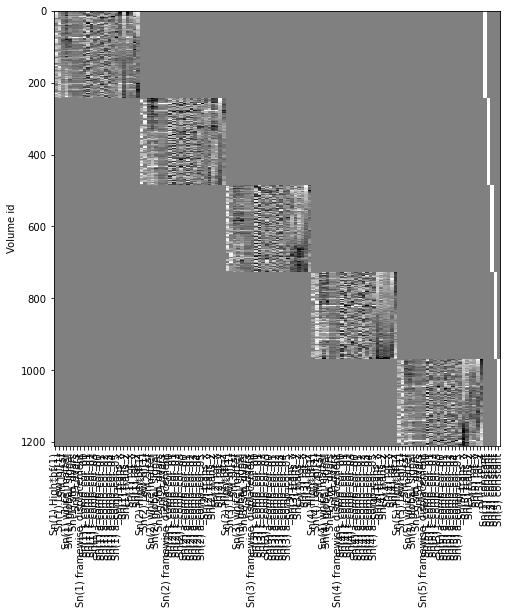

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

### visualise results

In [65]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/sub-06/anat/sub-06_desc-preproc_T1w.nii.gz'

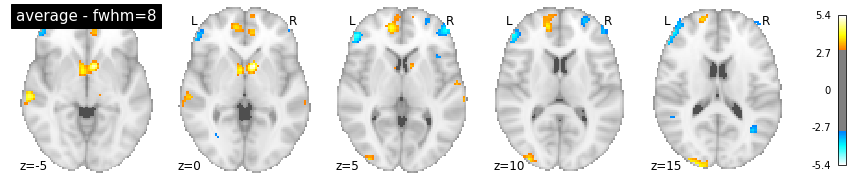

In [73]:
plot_stat_map(
    '/output/first_level/1stLevel/sub-06/spmT_0001.nii', title='average - fwhm=8', 
    threshold=3, display_mode='z', cut_coords=(-5, 0, 5, 10, 15))#, dim=-1);

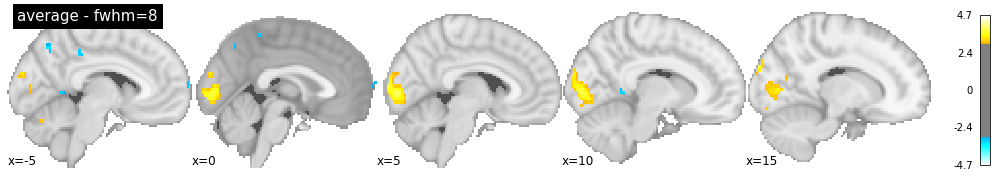

In [72]:
plot_stat_map(
    '/output/first_level/1stLevel/sub-06/spmT_0004.nii', title='average - fwhm=8', 
    threshold=3, display_mode='x', cut_coords=(-5, 0, 5, 10, 15))#, dim=-1);

In [69]:
from glob import glob
spmT_images = glob('/output/first_level/1stLevel/sub-06/con*')
spmT_images

['/output/first_level/1stLevel/sub-06/con_0001.nii',
 '/output/first_level/1stLevel/sub-06/con_0004.nii',
 '/output/first_level/1stLevel/sub-06/con_0002.nii',
 '/output/first_level/1stLevel/sub-06/con_0003.nii',
 '/output/first_level/1stLevel/sub-06/con_0005.nii']

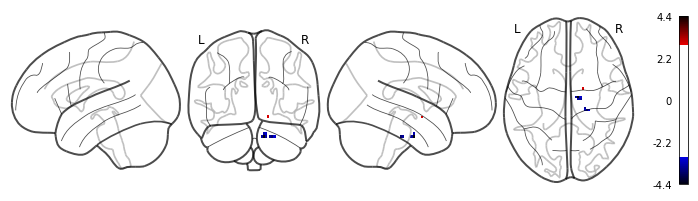

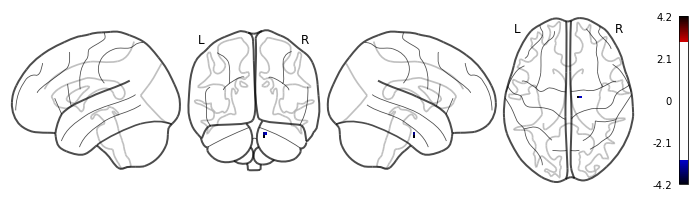

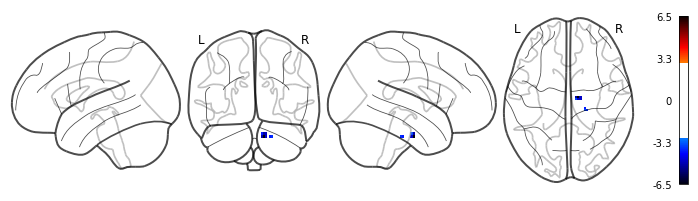

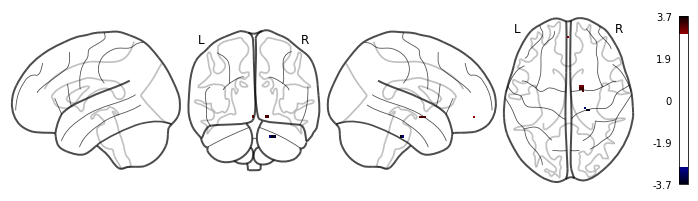

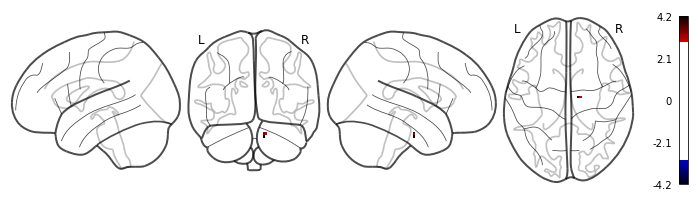

In [71]:
for con_image in spmT_images:
    nilearn.plotting.plot_glass_brain(con_image,
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=3)

### visualise workflow

201002-09:32:11,91 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


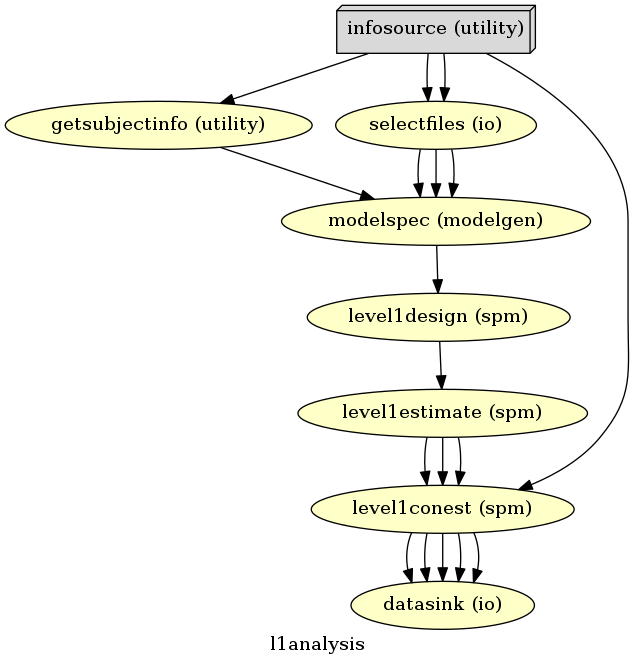

In [25]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))